# N Classes Object Localisation

In [1]:
from tqdm import tqdm

import numpy as np

In [2]:
%run ../src/core.py
%run ../src/layers.py
%run ../src/loss.py
%run ../src/network.py
%run ../src/metrics.py

## Dataset creation


In [3]:
from PIL import Image

import glob
import xml.etree.ElementTree as ET

In [4]:
!kaggle datasets download -d danielpancake/image-localization-dataset

Dataset URL: https://www.kaggle.com/datasets/danielpancake/image-localization-dataset
License(s): unknown




  0%|          | 0.00/1.71M [00:00<?, ?B/s]
 59%|█████▊    | 1.00M/1.71M [00:00<00:00, 1.54MB/s]
100%|██████████| 1.71M/1.71M [00:00<00:00, 2.35MB/s]


In [5]:
class Dataset:
    def __init__(self, path: str, transform=None):
        self.path = path
        self.transform = transform

        self.images = []
        self.labels_class = []
        self.labels_bbox = []

        self.classes = {}

        self._load_data()

    def _load_data(self):
        # Get all xml files in folder training_images
        xml_files = glob.glob(f"{self.path}/*.xml")

        for annotation in tqdm(xml_files):
            tree = ET.parse(annotation)
            root = tree.getroot()

            # Read image
            image_path = root.find("filename").text
            image = self._read_image(f"{self.path}/{image_path}")

            if self.transform:
                image = self.transform(image)

            self.images.append(image)

            # Read class name
            obj = root.find("object")
            class_name = obj.find("name").text

            if class_name not in self.classes:
                self.classes[class_name] = len(self.classes)

            # Encode class name as integer
            self.labels_class.append(self.classes[class_name])

            # Read bbox
            obj_bbox = obj.find("bbox")

            xmin = int(obj_bbox.find("xmin").text)
            ymin = int(obj_bbox.find("ymin").text)
            xmax = int(obj_bbox.find("xmax").text)
            ymax = int(obj_bbox.find("ymax").text)

            bbox = np.array([xmin, ymin, xmax, ymax])
            self.labels_bbox.append(bbox)

        # Convert to numpy array
        self.images = np.array(self.images)
        self.labels_class = np.array(self.labels_class)
        self.labels_bbox = np.array(self.labels_bbox)

    def _read_image(self, image_path: str):
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = image.resize((64, 64))
        image = np.array(image)

        return image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels_class[idx], self.labels_bbox[idx]

In [6]:
def prepocess_image(image: np.ndarray) -> np.ndarray:
    # Normalize image
    image = image.astype(np.float32)
    image /= 255.0

    # Reshape the images to (B, C, H, W)
    image = image.transpose(2, 0, 1)[None, ...]

    return image

In [7]:
dataset = Dataset("training_images", transform=prepocess_image)

# Separate white background from the rest
nothing_mask = dataset.labels_class == dataset.classes["nothing"]

## Process the labels
# Class labels -> one-hot encoding
# Bounding box -> normalize to [0, 1]
dataset.labels_class = np.eye(len(dataset.classes))[dataset.labels_class]
dataset.labels_bbox = dataset.labels_bbox / 227.0

# Reshape the labels
dataset.labels_class = dataset.labels_class[:, :, None]
dataset.labels_bbox = dataset.labels_bbox[:, :, None]

100%|██████████| 170/170 [00:00<00:00, 726.46it/s]


### Dataset preview


In [8]:
from matplotlib import patches
from matplotlib import pyplot as plt


def plot_sample(image: np.ndarray, loc: np.ndarray, true_loc: np.ndarray = None):
    ww, hh, __ = image.shape

    x1, y1, x2, y2 = loc * np.array([ww, hh, ww, hh])
    loc_ww = x2 - x1
    loc_hh = y2 - y1

    plt.imshow(image)
    ax = plt.gca()
    rect = patches.Rectangle(
        xy=(x1, y1),
        width=loc_ww,
        height=loc_hh,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)

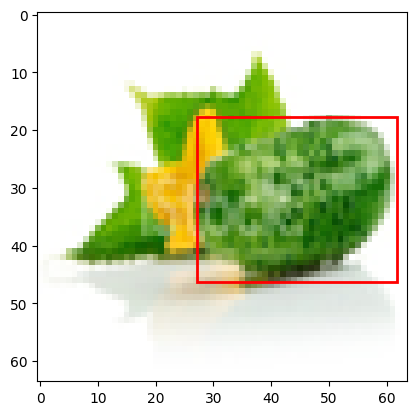

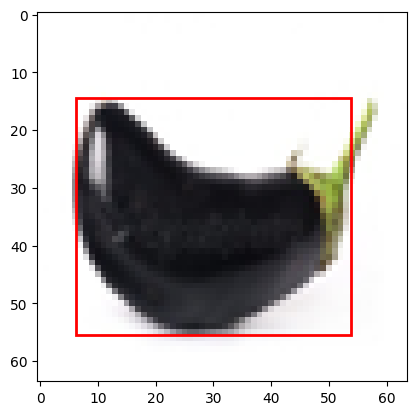

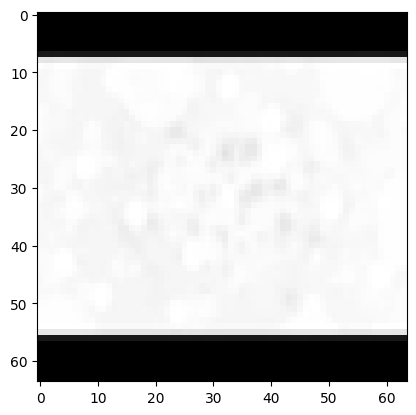

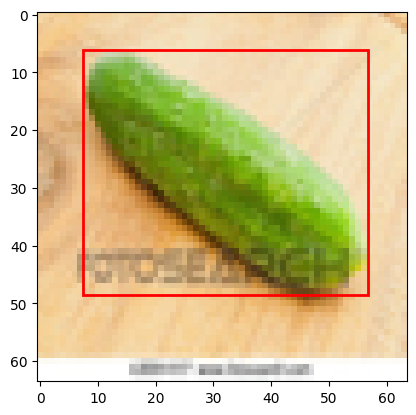

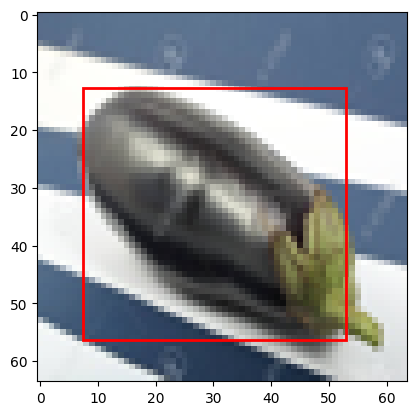

In [9]:
for idx in np.random.randint(0, len(dataset), 5):
    plot_sample(
        dataset.images[idx][0].transpose(1, 2, 0),
        dataset.labels_bbox[idx].flatten(),
    )
    plt.show()

In [10]:
dataset[0][0].shape

(1, 3, 64, 64)

## Model and training


In [11]:
class Classifier(Network):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__(
            [
                Conv2d(in_channels, num_filters=1, kernel_size=9),
                ReLU(),
                Flatten((1, 1, 56, 56)),
                Linear(1 * 1 * 56 * 56, 1024),
                ReLU(),
                Linear(1024, num_classes),
                Softmax(),
            ],
            CrossEntropy(),
            argmax_equal,
        )


class BBOXer(Network):
    def __init__(self, in_channels: int):
        super().__init__(
            [
                Conv2d(in_channels, num_filters=1, kernel_size=9),
                ReLU(),
                Flatten((1, 1, 56, 56)),
                Linear(1 * 1 * 56 * 56, 1024),
                ReLU(),
                Linear(1024, 4),
                Sigmoid(),
            ],
            SSE(),
            jaccard_coefficient,
        )

In [12]:
classifier = Classifier(3, len(dataset.classes))
classifier.train(
    x=dataset.images,
    y=dataset.labels_class,
    val_x=dataset.images,
    val_y=dataset.labels_class,
    epochs=8,
    lr=0.001,
    shuffle=True,
)

Epoch 1/8


100%|██████████| 170/170 [00:05<00:00, 28.94it/s, loss=1.02]


Evaluating... Validation score: 72.94118%
Epoch 2/8


100%|██████████| 170/170 [00:05<00:00, 30.15it/s, loss=0.612]


Evaluating... Validation score: 81.76471%
Epoch 3/8


100%|██████████| 170/170 [00:05<00:00, 30.49it/s, loss=0.355]


Evaluating... Validation score: 90.00000%
Epoch 4/8


100%|██████████| 170/170 [00:05<00:00, 30.34it/s, loss=0.233]


Evaluating... Validation score: 92.35294%
Epoch 5/8


100%|██████████| 170/170 [00:05<00:00, 28.59it/s, loss=0.26] 


Evaluating... Validation score: 96.47059%
Epoch 6/8


100%|██████████| 170/170 [00:05<00:00, 31.87it/s, loss=0.149]


Evaluating... Validation score: 97.05882%
Epoch 7/8


100%|██████████| 170/170 [00:05<00:00, 33.52it/s, loss=0.113] 


Evaluating... Validation score: 97.05882%
Epoch 8/8


100%|██████████| 170/170 [00:05<00:00, 32.96it/s, loss=0.094] 


Evaluating... Validation score: 98.82353%


In [13]:
bboxer = BBOXer(3)
bboxer.train(
    x=dataset.images[~nothing_mask],
    y=dataset.labels_bbox[~nothing_mask],
    val_x=dataset.images[~nothing_mask],
    val_y=dataset.labels_bbox[~nothing_mask],
    epochs=8,
    lr=0.001,
    shuffle=True,
)

Epoch 1/8


100%|██████████| 125/125 [00:04<00:00, 30.07it/s, loss=0.104]


Evaluating... Validation score: 54.73748%
Epoch 2/8


100%|██████████| 125/125 [00:04<00:00, 30.88it/s, loss=0.0579]


Evaluating... Validation score: 56.81725%
Epoch 3/8


100%|██████████| 125/125 [00:04<00:00, 30.38it/s, loss=0.0516]


Evaluating... Validation score: 58.49746%
Epoch 4/8


100%|██████████| 125/125 [00:04<00:00, 30.10it/s, loss=0.0467]


Evaluating... Validation score: 60.00701%
Epoch 5/8


100%|██████████| 125/125 [00:04<00:00, 29.87it/s, loss=0.0428]


Evaluating... Validation score: 61.30038%
Epoch 6/8


100%|██████████| 125/125 [00:03<00:00, 33.01it/s, loss=0.0396]


Evaluating... Validation score: 62.14445%
Epoch 7/8


100%|██████████| 125/125 [00:03<00:00, 32.86it/s, loss=0.0368]


Evaluating... Validation score: 62.56579%
Epoch 8/8


100%|██████████| 125/125 [00:03<00:00, 33.20it/s, loss=0.0345]


Evaluating... Validation score: 62.66973%


## Model inference


In [14]:
dataset.classes

{'nothing': 0, 'cucumber': 1, 'eggplant': 2}

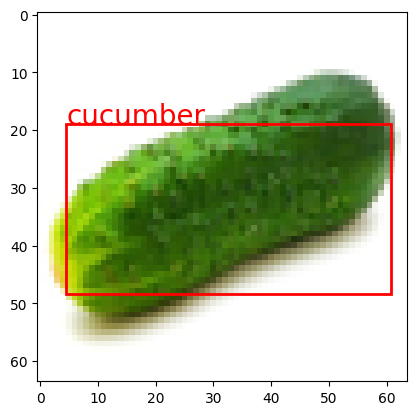

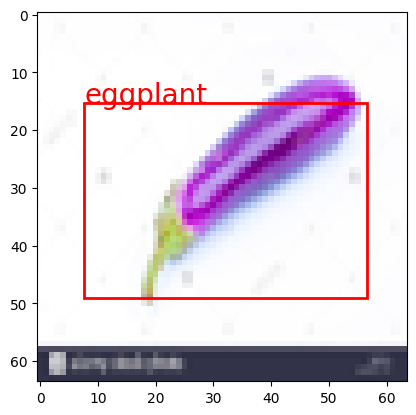

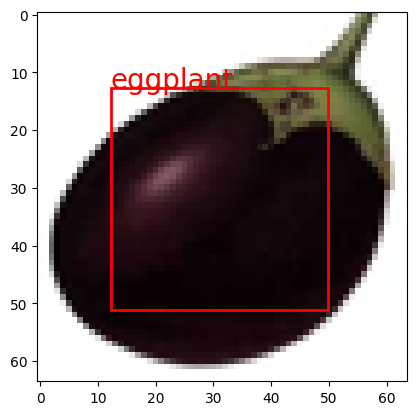

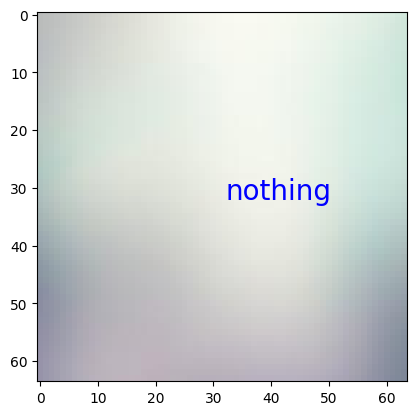

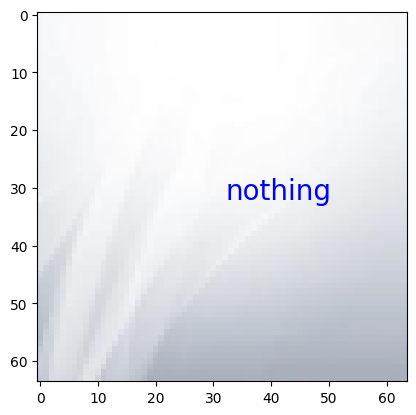

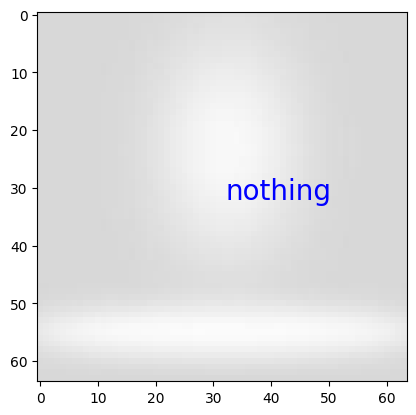

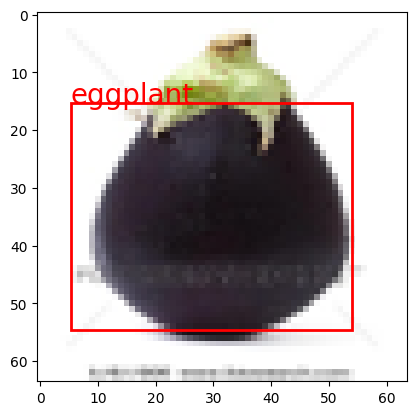

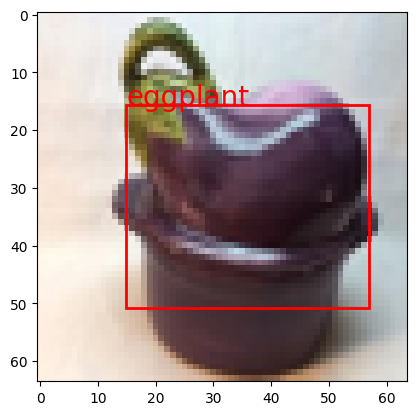

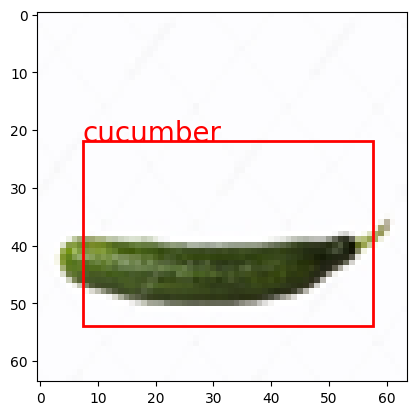

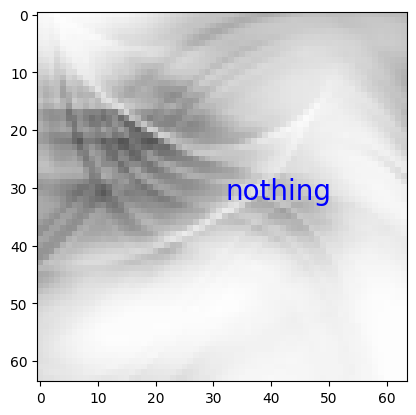

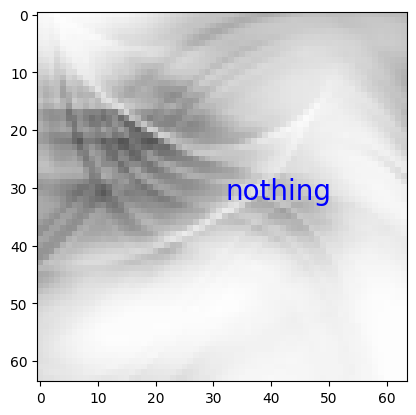

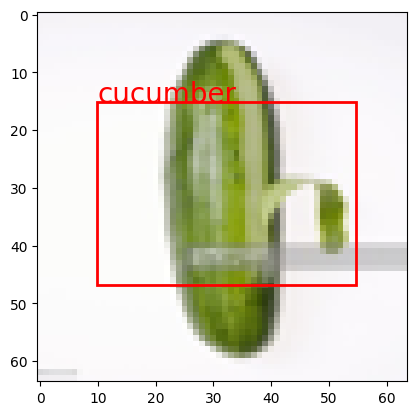

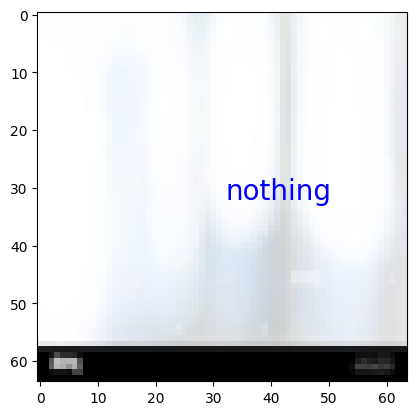

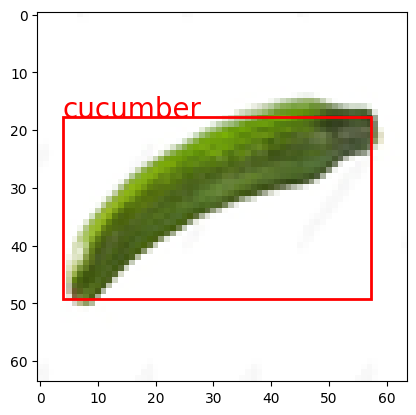

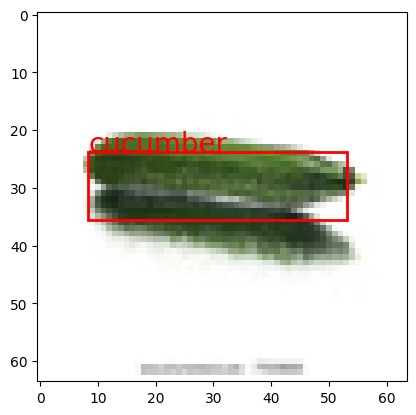

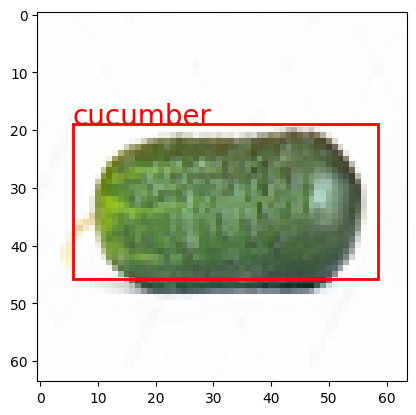

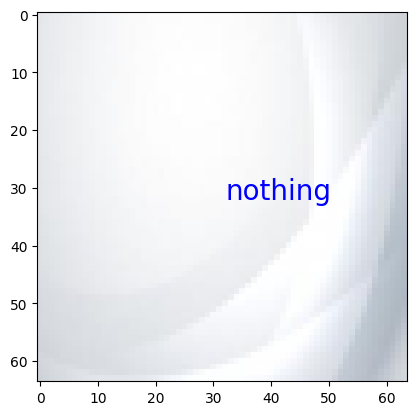

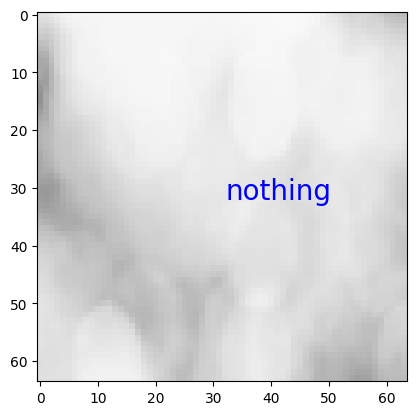

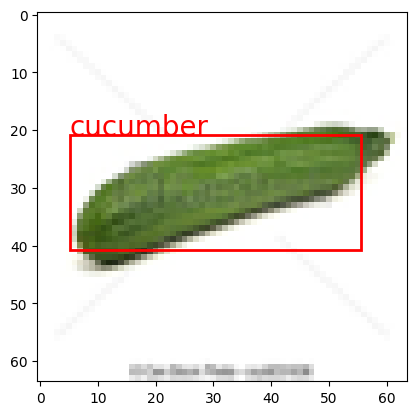

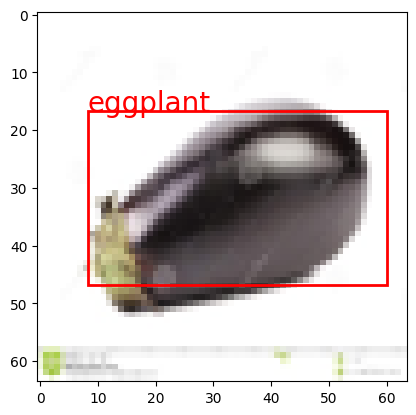

In [15]:
for idx in np.random.randint(0, len(dataset), 20):
    pred_class = classifier.forward(dataset.images[idx])

    # Skip if the classifier predicts "nothing"
    img = dataset.images[idx][0].transpose(1, 2, 0)

    if np.argmax(pred_class) == dataset.classes["nothing"]:
        plot_sample(img, [0, 0, 0, 0])
        plt.text(
            0.5 * 64.0,
            0.5 * 64.0,
            "nothing",
            color="blue",
            fontsize=20,
        )
    else:
        pred_bbox = bboxer.forward(dataset.images[idx]).flatten()
        plot_sample(img, pred_bbox)

        # Write name of the class
        plt.text(
            pred_bbox[0] * 64.0,
            pred_bbox[1] * 64.0,
            list(dataset.classes.keys())[np.argmax(pred_class)],
            color="red",
            fontsize=20,
        )
    plt.show()